<a href="https://colab.research.google.com/github/srilav/machinelearning/blob/main/Team_11_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import glob

In [ ]:
!pip -qq install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

ERROR: Operation cancelled by user


In [ ]:
import datetime
import os
from finrl import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
import sys
sys.path.append("../FinRL-Library")

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_percentage_error
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier

In [ ]:
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential

In [ ]:
pd.options.display.max_rows = 25
pd.options.display.max_columns = 25

In [ ]:
path = '/content/ind_nifty50list.csv'
df_stocks = pd.read_csv(path).fillna(0)

In [ ]:
df_stocks.head()

,Company Name,Industry,Symbol,Series,ISIN Code
0,Adani Ports and Special Economic Zone Ltd.,Services,ADANIPORTS,EQ,INE742F01042
1,Apollo Hospitals Enterprise Ltd.,Healthcare,APOLLOHOSP,EQ,INE437A01024
2,Asian Paints Ltd.,Consumer Durables,ASIANPAINT,EQ,INE021A01026
3,Axis Bank Ltd.,Financial Services,AXISBANK,EQ,INE238A01034
4,Bajaj Auto Ltd.,Automobile and Auto Components,BAJAJ-AUTO,EQ,INE917I01010


In [ ]:
df_stocks.groupby(by = ['Industry'])['Company Name'].count()

Industry
Automobile and Auto Components     6
Chemicals                          1
Construction                       1
Construction Materials             3
Consumer Durables                  2
Fast Moving Consumer Goods         5
Financial Services                11
Healthcare                         5
Information Technology             5
Metals & Mining                    3
Oil Gas & Consumable Fuels         4
Power                              2
Services                           1
Telecommunication                  1
Name: Company Name, dtype: int64

In [ ]:
len(df_stocks)

50

In [ ]:
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# ax.axis('equal')
# Industry = ['Automobile and Auto Components', 'Chemicals', 'Construction', 'Construction Materials',  'Consumer Durables', 
#             'Fast Moving Consumer Goods', 'Fast Moving Consumer Goods', 'Healthcare', 'Information Technology', 'Metals & Mining', 
#             'Oil Gas & Consumable Fuels', 'Power', 'Services']
# ax.pie(len(df_stocks.groupby(by = ['Industry']).count())/labels = Industry, autopct='%1.2f%%')
# plt.show()

ANALYSIS USING DEEP REINFORCEMENT LEARNING

In [ ]:
df_stocks['Symbol'] = df_stocks['Symbol'].astype(str) + '.NS'

In [ ]:
stocks_list = df_stocks['Symbol'].tolist()

In [ ]:
start_date = '2014-01-01'
end_date = '2021-12-01'

df_NSE = YahooDownloader(start_date = start_date,
                     end_date = end_date,
                     ticker_list = stocks_list).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
""" Perform Feature Engineering """
df_NSE = FeatureEngineer(use_technical_indicator=True,
                                      tech_indicator_list = config.INDICATORS,
                                      use_turbulence=True,
                                      user_defined_feature = False).preprocess_data(df_NSE.copy())

Successfully added technical indicators
Successfully added turbulence index


In [ ]:
df_NSE.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day', 'macd',
       'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma',
       'close_60_sma', 'turbulence'],
      dtype='object')

In [ ]:
df_NSE.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2014-01-01,154.550003,157.750000,154.550003,150.426819,851727,ADANIPORTS.NS,2,0.0,153.638312,143.702478,0.0,-66.666667,100.0,150.426819,150.426819,0.0
1,2014-01-01,940.250000,987.650024,940.250000,938.716614,335988,APOLLOHOSP.NS,2,0.0,153.638312,143.702478,0.0,-66.666667,100.0,938.716614,938.716614,0.0
2,2014-01-01,494.399994,503.899994,492.000000,471.825500,1866326,ASIANPAINT.NS,2,0.0,153.638312,143.702478,0.0,-66.666667,100.0,471.825500,471.825500,0.0
3,2014-01-01,260.299988,261.000000,257.640015,248.631042,2849425,AXISBANK.NS,2,0.0,153.638312,143.702478,0.0,-66.666667,100.0,248.631042,248.631042,0.0
4,2014-01-01,1915.000000,1924.400024,1890.300049,1560.954224,90587,BAJAJ-AUTO.NS,2,0.0,153.638312,143.702478,0.0,-66.666667,100.0,1560.954224,1560.954224,0.0


In [ ]:
df_NSE['close'].groupby(df_NSE['tic']).mean()

tic
ADANIPORTS.NS     359.620345
APOLLOHOSP.NS    1547.908139
ASIANPAINT.NS    1340.821980
AXISBANK.NS       547.310524
BAJAJ-AUTO.NS    2530.525631
                    ...     
TECHM.NS          599.818804
TITAN.NS          796.532043
ULTRACEMCO.NS    3904.574742
UPL.NS            432.897489
WIPRO.NS          255.302200
Name: close, Length: 48, dtype: float64

In [ ]:
# plt.figure(figsize=(24,20))
# plt.bar(df_NSE['tic'], df_NSE['close'].mean())
# plt.tight_layout()
# plt.show()

**STOCK PRICE PREDICTION USING ARIMA**

In [ ]:
from pandas.plotting import lag_plot
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [ ]:
print(df_NSE.shape)
print(df_NSE.columns)

(93552, 17)
Index(['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day', 'macd',
       'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma',
       'close_60_sma', 'turbulence'],
      dtype='object')


In [ ]:
df_NSE.isna().sum()

date            0
open            0
high            0
low             0
close           0
volume          0
tic             0
day             0
macd            0
boll_ub         0
boll_lb         0
rsi_30          0
cci_30          0
dx_30           0
close_30_sma    0
close_60_sma    0
turbulence      0
dtype: int64

In [ ]:
df_NSE['date'] = pd.to_datetime(df_NSE['date'])
df_NSE.set_index('date')
df_NSE.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2014-01-01,154.550003,157.750000,154.550003,150.426804,851727,ADANIPORTS.NS,2,0.0,153.638297,143.702462,0.0,-66.666667,100.0,150.426804,150.426804,0.0
1,2014-01-01,940.250000,987.650024,940.250000,938.716553,335988,APOLLOHOSP.NS,2,0.0,153.638297,143.702462,0.0,-66.666667,100.0,938.716553,938.716553,0.0
2,2014-01-01,494.399994,503.899994,492.000000,471.825562,1866326,ASIANPAINT.NS,2,0.0,153.638297,143.702462,0.0,-66.666667,100.0,471.825562,471.825562,0.0
3,2014-01-01,260.299988,261.000000,257.640015,248.631027,2849425,AXISBANK.NS,2,0.0,153.638297,143.702462,0.0,-66.666667,100.0,248.631027,248.631027,0.0
4,2014-01-01,1915.000000,1924.400024,1890.300049,1560.954346,90587,BAJAJ-AUTO.NS,2,0.0,153.638297,143.702462,0.0,-66.666667,100.0,1560.954346,1560.954346,0.0


In [ ]:
type(df_NSE)

pandas.core.frame.DataFrame

In [ ]:
df_NSE['date'][::-1]

93551   2021-11-30
93550   2021-11-30
93549   2021-11-30
93548   2021-11-30
93547   2021-11-30
           ...    
4       2014-01-01
3       2014-01-01
2       2014-01-01
1       2014-01-01
0       2014-01-01
Name: date, Length: 93552, dtype: datetime64[ns]

In [ ]:
tictic = df_NSE['close'].loc[df_NSE['tic'] == 'ASIANPAINT.NS']

In [ ]:
print(tictic)

2         471.825562
50        458.418945
98        462.148224
146       463.234039
194       462.573151
            ...     
93314    3157.000000
93362    3144.250000
93410    3143.100098
93458    3144.300049
93506    3143.649902
Name: close, Length: 1949, dtype: float64


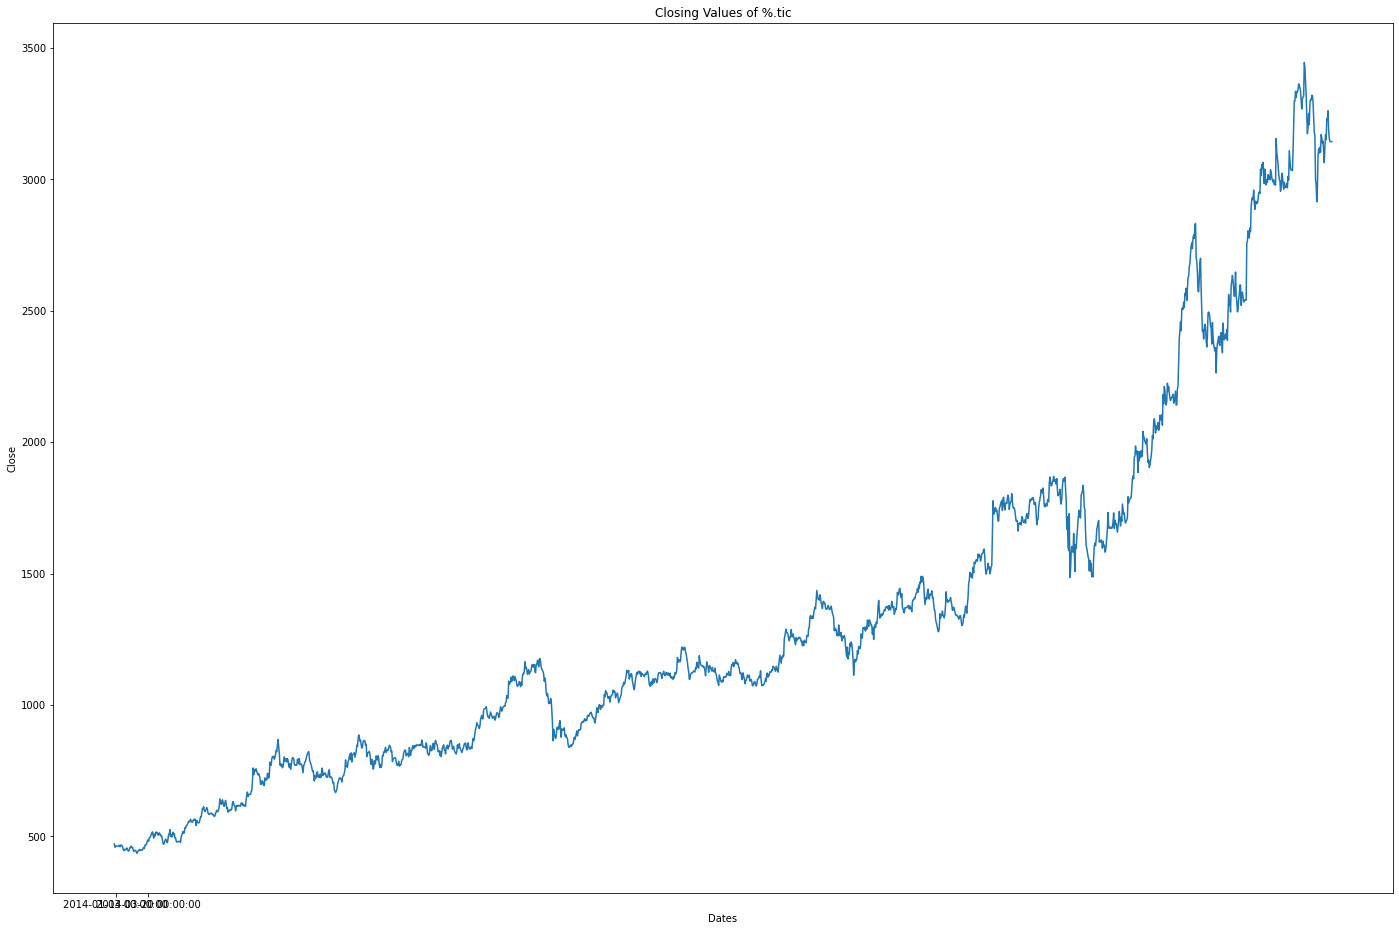

In [ ]:
plt.figure(figsize=(24,16))
plt.plot(tictic)
plt.title('Closing Values of %.tic')
plt.xlabel('Dates')
plt.ylabel('Close')
plt.xticks(np.arange(100,5000, 2500), df_NSE['date'][100:5000:2500])
plt.show()

In [ ]:
# Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(df_NSE.close, autolag='AIC', maxlag = 20)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
pvalue = dftest[1]
if pvalue < 0.01:
    print('p-value = %.4f. The series is likely stationary.' % pvalue)
else:
    print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

print(dfoutput)

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                   -45.328338
p-value                            0.000000
#Lags Used                        20.000000
Number of Observations Used    93531.000000
Critical Value (1%)               -3.430420
Critical Value (5%)               -2.861571
Critical Value (10%)              -2.566786
dtype: float64


The stock price series of Asian Paints is stationary and reflects a random walk model (similar to a drunk man!) 



Text(0.5, 1.0, ' Autocorrelation plot of Asian Paints stock')

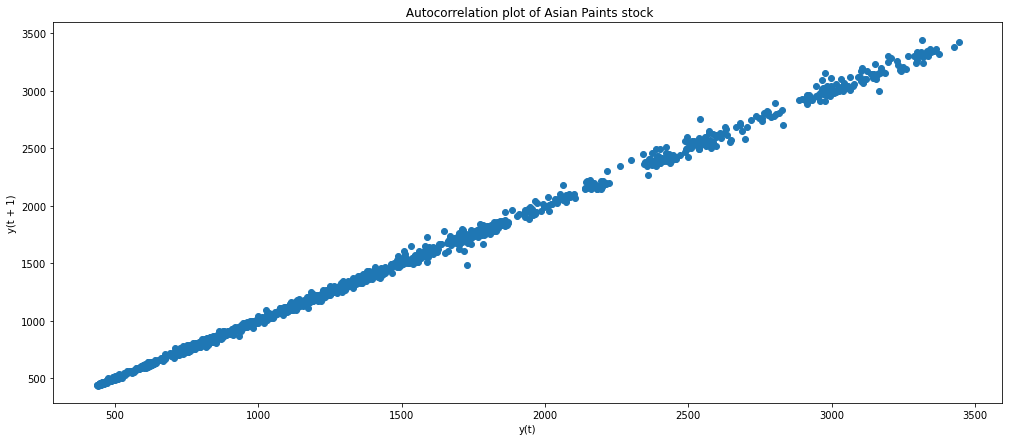

In [ ]:
# plt.figure(figsize=(17,7))
# lag_plot(tictic, lag=1)
# plt.title(' Autocorrelation plot of Asian Paints stock')

Divide the data into train, test and split

In [ ]:
train_data, test_data = df_NSE[0:int(len(df_NSE)*0.8)], df_NSE[int(len(df_NSE)*0.8):]

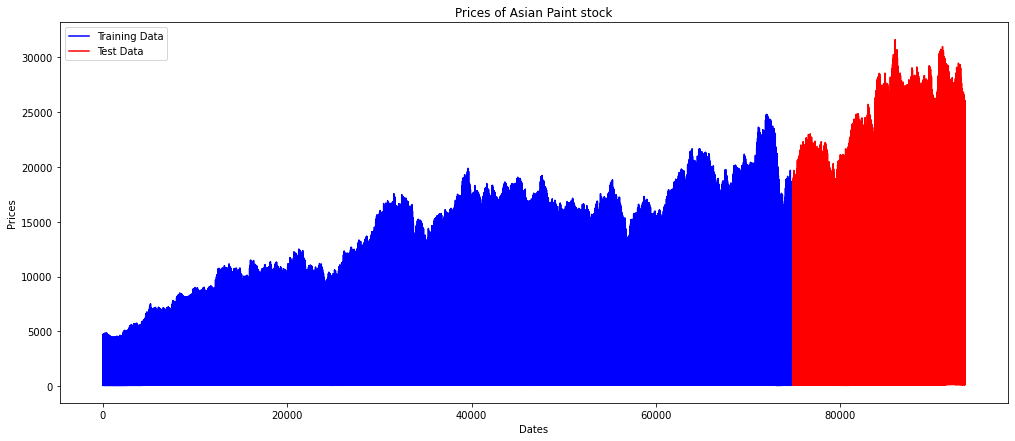

In [ ]:
plt.figure(figsize=(17,7))
plt.title("Prices of Asian Paint stock")
plt.xlabel("Dates")
plt.ylabel("Prices")
plt.plot(train_data['close'], 'blue', label = "Training Data")
plt.plot(test_data['close'], 'red', label = "Test Data")
plt.legend()
plt.show()

Plotting ACF and PACF plots to check ARIMA model order

In [ ]:
fig = plt.figure(fgsize=(15,7))
ax1 = fig.subplot(211)
fig = sm.graphics.tsa.plot_acf(diff, )